In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

1. Block-matching using a sliding window of radius w and either the Sum of Absolute Differences (SAD) or Sum of Squared Differences (SSD) cost.

2. Scanline dynamic programming (DP) to enforce an ordering constraint and handle occlusions at the 1D row level, with a noise-weighted matching cost and occlusion penalty.

Block-matching finds, for each pixel, the shift (disparity) along the epipolar line that minimizes a local windowed cost; DP finds a globally optimal alignment path through a cost matrix for each scanline, labeling pixels as matched or occluded.

In [9]:
def compute_disparity_block_matching(Il, Ir, max_disp, w, method='SAD'):
    """
    Compute disparity map by block matching.
      Il, Ir   : grayscale left/right images as 2D numpy arrays
      max_disp : maximum disparity (pixels to search)
      w        : window radius (window size = 2*w+1)
      method   : 'SAD' or 'SSD'
    Returns:
      disp     : disparity map (same size as Il), dtype=float
    """
    h, w_img = Il.shape
    disp = np.zeros_like(Il, dtype=np.float32)
    half = w

    # pad images to handle borders
    pad = half + max_disp
    Il_p = np.pad(Il, ((0,0),(pad,pad)), mode='constant', constant_values=0)
    Ir_p = np.pad(Ir, ((0,0),(pad,pad)), mode='constant', constant_values=0)

    for y in range(half, h-half):
        for x in range(half, w_img-half):
            best_cost = np.inf
            best_d = 0
            # left window
            block_l = Il_p[y: y+2*half+1, x+pad: x+pad+2*half+1]
            # search over disparities
            for d in range(max_disp+1):
                x_r = x + pad - d
                block_r = Ir_p[y: y+2*half+1, x_r: x_r+2*half+1]
                if method == 'SAD':
                    cost = np.sum(np.abs(block_l - block_r))
                else:  # SSD
                    cost = np.sum((block_l - block_r)**2)
                if cost < best_cost:
                    best_cost = cost
                    best_d = d
            disp[y, x] = best_d
    return disp


In [10]:
def stereo_dp_scanline(Il_row, Ir_row, sigma=2.0, c0=1.0):
    """
    Compute disparity for one scanline by dynamic programming.
      Il_row, Ir_row : 1D numpy arrays of grayscale intensities
      sigma          : noise parameter
      c0             : occlusion penalty
    Returns:
      dl, dr         : disparity arrays for left and right scanline
      D              : full cost matrix
    """
    N = len(Il_row)
    # cost matrix D of size (N+1)x(N+1)
    D = np.zeros((N+1,N+1), dtype=np.float32)
    # initialize
    for i in range(1, N+1):
        D[i,0] = i * c0
        D[0,i] = i * c0

    # fill
    for i in range(1, N+1):
        for j in range(1, N+1):
            dij = ((Il_row[i-1] - Ir_row[j-1])**2) / (sigma**2)
            D[i,j] = min(D[i-1,j-1] + dij,
                         D[i-1,j]   + c0,
                         D[i,j-1]   + c0)

    # backtrack
    i, j = N, N
    dl = np.zeros(N, dtype=np.int32)
    dr = np.zeros(N, dtype=np.int32)
    while i>0 or j>0:
        # match
        if i>0 and j>0 and D[i,j] == D[i-1,j-1] + ((Il_row[i-1]-Ir_row[j-1])**2)/(sigma**2):
            dl[i-1] = abs(i-j)
            dr[j-1] = abs(i-j)
            i, j = i-1, j-1
        # skip left
        elif i>0 and D[i,j] == D[i-1,j] + c0:
            i -= 1
        # skip right
        else:
            j -= 1

    return dl, dr, D

In [11]:
def plot_alignment(D):
    """
    Given DP cost matrix D, plot the alignment path.
    Vertical = skip in Il, horizontal = skip in Ir, diagonal = match.
    """
    i, j = D.shape[0]-1, D.shape[1]-1
    path = [(i,j)]
    while i>0 or j>0:
        opts = []
        if i>0 and j>0:
            opts.append((D[i-1,j-1], i-1, j-1, 'diag'))
        if i>0:
            opts.append((D[i-1,j], i-1, j, 'vert'))
        if j>0:
            opts.append((D[i,j-1], i, j-1, 'horiz'))
        cost, ni, nj, move = min(opts, key=lambda x: x[0])
        path.append((ni,nj,move))
        i, j = ni, nj

    # separate coords and moves
    xs, ys, moves = zip(*[(j,i,m) for (i,j,*m) in path])
    plt.figure()
    plt.plot(xs, ys, '-o')
    for (x,y,move) in path:
        if move=='vert':
            plt.vlines(x, y, y+1)
        elif move=='horiz':
            plt.hlines(y, x, x+1)
        else:
            plt.plot([x,x+1],[y,y+1])
    plt.gca().invert_yaxis()
    plt.xlabel('IR index j'); plt.ylabel('IL index i')
    plt.title('DP Alignment Path')
    plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5900\821973506.py:22: RuntimeWarning: overflow encountered in scalar subtract
  dij = ((Il_row[i-1] - Ir_row[j-1])**2) / (sigma**2)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5900\821973506.py:33: RuntimeWarning: overflow encountered in scalar subtract
  if i>0 and j>0 and D[i,j] == D[i-1,j-1] + ((Il_row[i-1]-Ir_row[j-1])**2)/(sigma**2):


ValueError: not enough values to unpack (expected 3, got 2)

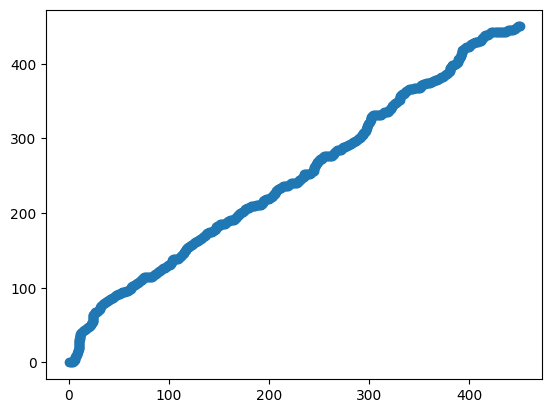

In [12]:
Il = cv2.imread(r"stereo_materials\l2.png", cv2.IMREAD_GRAYSCALE)
Ir = cv2.imread(r"stereo_materials\r2.png", cv2.IMREAD_GRAYSCALE)
max_disp = 64

# produce six maps
disps = {}
for w in [0,2,4]:
    for method in ['SAD','SSD']:
        key = f'{method}_w{2*w+1}'
        disps[key] = compute_disparity_block_matching(Il, Ir, max_disp, w, method)
        cv2.imwrite(f'disp_{key}.png', (disps[key]/max_disp*255).astype(np.uint8))
#----------------------------------------------------------------------------------#
h, w = Il.shape
disp_dp = np.zeros_like(Il, dtype=np.int32)
for y in range(h):
    dl, dr, _ = stereo_dp_scanline(Il[y,:], Ir[y,:], sigma=2.0, c0=1.0)
    disp_dp[y,:] = dl
cv2.imwrite('disp_dp.png', (disp_dp.astype(np.float32)/max_disp*255).astype(np.uint8))
#----------------------------------------------------------------------------------#
_, _, D_mid = stereo_dp_scanline(Il[h // 2, :], Ir[h // 2, :])
plot_alignment(D_mid)



